# activations, gradients, batchnorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [14]:
# build vocab chars and mappings
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [89]:
# MLP revisited
n_emb = 10 # dimension of each char vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) # lookup table - each row is the embedding of a char (27x10)
W1 = torch.rand((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size)**0.5)                 # 0.1
b1 = torch.rand(n_hidden, generator=g) * 0.01
W2 = torch.rand((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.rand(vocab_size, generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C,W1,b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of total parameters of the model
for p in parameters:
  p.requires_grad = True

12297


In [90]:
# optimization from last time
max_steps = 10000
batch_size = 32 # in a batch 32 X,Y pairs will be used
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # picks batch_size random context from X
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embeddings of Xb
  embcat = emb.view(emb.shape[0], n_emb * block_size) # reshape emb to (batch_size, n_emb * block_size)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation - we want this to be close to 0
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/  10000: 3.3000
   1000/  10000: 2.7108
   2000/  10000: 2.3007
   3000/  10000: 2.5147
   4000/  10000: 2.6488
   5000/  10000: 2.2557
   6000/  10000: 2.4729
   7000/  10000: 2.6271
   8000/  10000: 2.3313
   9000/  10000: 2.2144


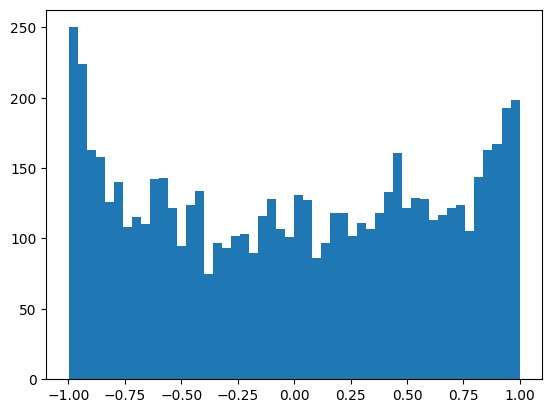

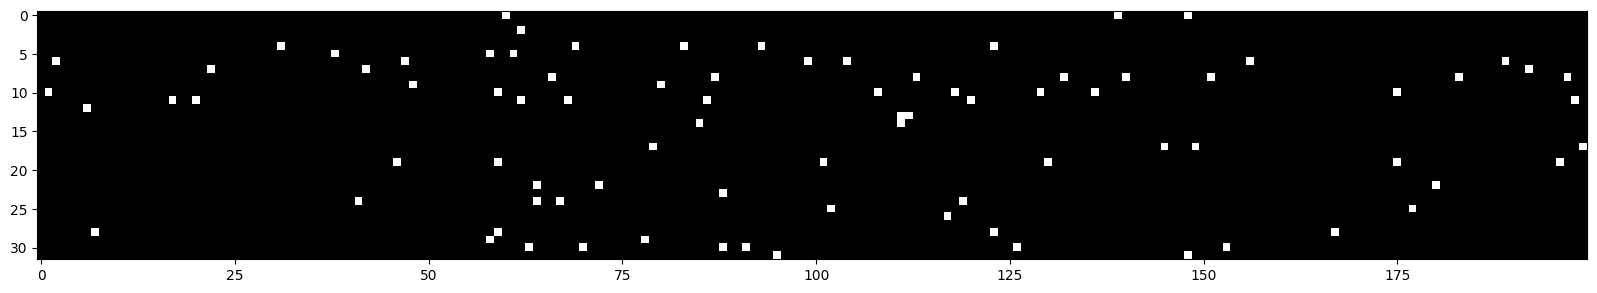

In [91]:
plt.hist(h.view(-1).tolist(), 50)

# outputs of hidden layer activations. because of the derivative of tanh -1,1 will cause gradient vanish.
# currently there are so may -1 and 1s.

# boolean tensor for visualizing -1 and 1 activations in h()
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

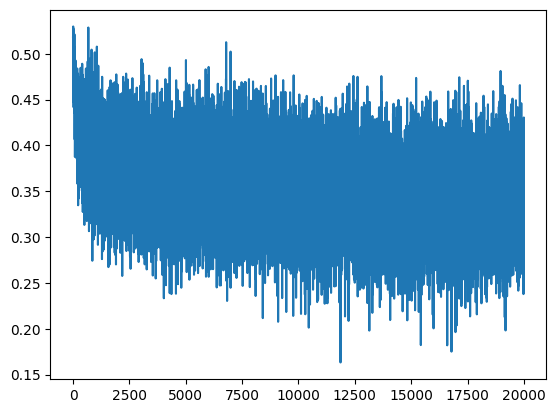

In [76]:
plt.plot(lossi)

In [97]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through the network
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)



In [98]:
@torch.no_grad() # decorator to diable gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_emb)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.241286516189575
val 2.253167152404785


In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
  out =[]
  context = [0] * block_size
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))


junide.
cas.
kah.
paysay.
adin.
koi.
rito.
cous.
tem.
kalinaa.
zamilenias.
dedainr.
imba.
seon.
evy.
arte.
farium.
kyfontumj.
phynslen.
rute.
